In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

# Set random seed untuk reproducibility
tf.random.set_seed(42)
np.random.seed(42)

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [4]:
# Load dataset MNIST
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Data training shape: {x_train.shape}")
print(f"Data testing shape: {x_test.shape}")
print(f"Label training shape: {y_train.shape}")
print(f"Label testing shape: {y_test.shape}")

# Preprocessing data untuk Transfer Learning
def preprocess_data(images, labels):
    # Konversi ke 3 channel (RGB) untuk model pre-trained
    images_rgb = np.stack([images] * 3, axis=-1)

    # Resize ke 32x32 (ukuran minimum untuk banyak model pre-trained)
    images_resized = tf.image.resize(images_rgb, [32, 32]).numpy()

    # Normalisasi ke range [0, 1]
    images_normalized = images_resized / 255.0

    # One-hot encoding labels
    labels_categorical = to_categorical(labels, 10)

    return images_normalized, labels_categorical

# Preprocess data training dan testing
print("Preprocessing data...")
x_train_processed, y_train_processed = preprocess_data(x_train, y_train)
x_test_processed, y_test_processed = preprocess_data(x_test, y_test)

print(f"Data training setelah preprocessing: {x_train_processed.shape}")
print(f"Data testing setelah preprocessing: {x_test_processed.shape}")

Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data training shape: (60000, 28, 28)
Data testing shape: (10000, 28, 28)
Label training shape: (60000,)
Label testing shape: (10000,)
Preprocessing data...
Data training setelah preprocessing: (60000, 32, 32, 3)
Data testing setelah preprocessing: (10000, 32, 32, 3)


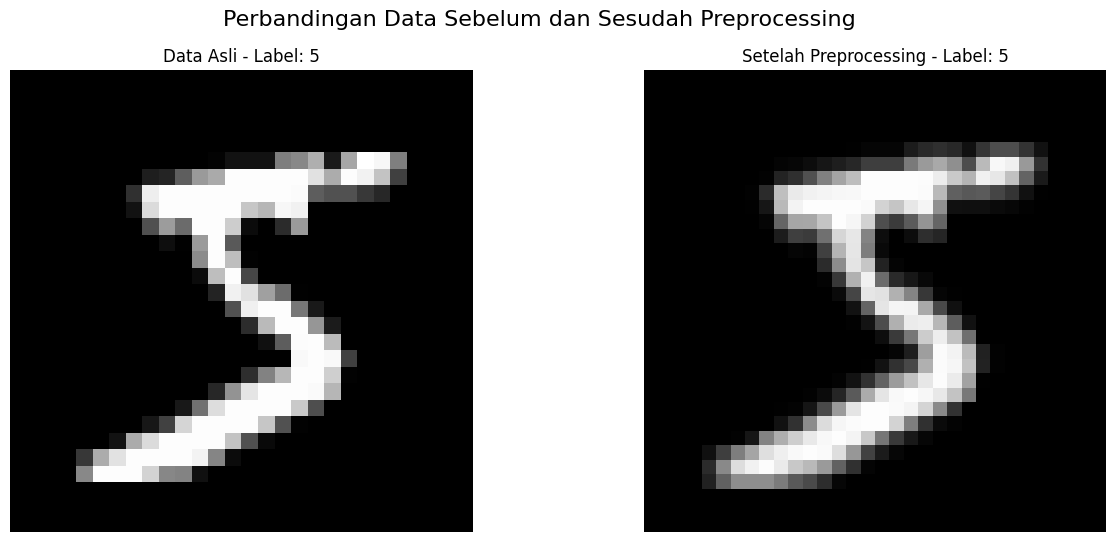

Shape data asli: (28, 28)
Shape setelah preprocessing: (32, 32, 3)
Range nilai pixel: [0.000, 1.000]


In [5]:
# Visualisasi contoh data setelah preprocessing
plt.figure(figsize=(15, 6))

# Contoh data asli
plt.subplot(1, 2, 1)
plt.imshow(x_train[0], cmap='gray')
plt.title(f'Data Asli - Label: {y_train[0]}')
plt.axis('off')

# Contoh data setelah preprocessing
plt.subplot(1, 2, 2)
plt.imshow(x_train_processed[0])
plt.title(f'Setelah Preprocessing - Label: {y_train[0]}')
plt.axis('off')

plt.suptitle('Perbandingan Data Sebelum dan Sesudah Preprocessing', fontsize=16)
plt.show()

print(f"Shape data asli: {x_train[0].shape}")
print(f"Shape setelah preprocessing: {x_train_processed[0].shape}")
print(f"Range nilai pixel: [{x_train_processed.min():.3f}, {x_train_processed.max():.3f}]")

In [6]:
# Membandingkan beberapa arsitektur pre-trained
def compare_pretrained_models():
    models_info = {
        'MobileNetV2': {
            'input_shape': (32, 32, 3),
            'model': MobileNetV2,
            'params': '3.4M',
            'size': '14MB'
        },
        'VGG16': {
            'input_shape': (32, 32, 3),
            'model': VGG16,
            'params': '138M',
            'size': '528MB'
        },
        'ResNet50': {
            'input_shape': (32, 32, 3),
            'model': ResNet50,
            'params': '25.6M',
            'size': '98MB'
        }
    }

    print("PERBANDINGAN ARSITEKTUR PRE-TRAINED")
    print("="*50)
    for name, info in models_info.items():
        print(f"{name}:")
        print(f"  - Input shape: {info['input_shape']}")
        print(f"  - Parameters: {info['params']}")
        print(f"  - Size: {info['size']}")
        print()

compare_pretrained_models()

# Pilih MobileNetV2 karena efisien dan cocok untuk dataset kecil
print("Memilih MobileNetV2 karena:")
print("- Efisien dalam komputasi")
print("- Cocok untuk dataset berukuran kecil")
print("- Performance yang baik pada berbagai tugas")

PERBANDINGAN ARSITEKTUR PRE-TRAINED
MobileNetV2:
  - Input shape: (32, 32, 3)
  - Parameters: 3.4M
  - Size: 14MB

VGG16:
  - Input shape: (32, 32, 3)
  - Parameters: 138M
  - Size: 528MB

ResNet50:
  - Input shape: (32, 32, 3)
  - Parameters: 25.6M
  - Size: 98MB

Memilih MobileNetV2 karena:
- Efisien dalam komputasi
- Cocok untuk dataset berukuran kecil
- Performance yang baik pada berbagai tugas


In [7]:
def create_transfer_learning_model(base_model_name='MobileNetV2'):
    """
    Membuat model Transfer Learning dengan base model pre-trained
    """
    # Pilih base model
    if base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(32, 32, 3)
        )
    elif base_model_name == 'VGG16':
        base_model = VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(32, 32, 3)
        )
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(32, 32, 3)
        )

    # Freeze base model (tidak melatih ulang weights)
    base_model.trainable = False

    # Bangun model lengkap
    inputs = Input(shape=(32, 32, 3))

    # Preprocessing input (sama seperti yang digunakan saat pre-training)
    if base_model_name == 'MobileNetV2':
        x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    elif base_model_name == 'VGG16':
        x = tf.keras.applications.vgg16.preprocess_input(inputs)
    elif base_model_name == 'ResNet50':
        x = tf.keras.applications.resnet50.preprocess_input(inputs)

    # Base model
    x = base_model(x, training=False)

    # Custom classifier head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model, base_model

# Membuat model
print("Membangun model Transfer Learning...")
model, base_model = create_transfer_learning_model('MobileNetV2')

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model berhasil dibuat!")
model.summary()

Membangun model Transfer Learning...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model berhasil dibuat!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,858 (9.27 MB)

 Trainable params: 172,874 (675.29 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

STRUKTUR MODEL TRANSFER LEARNING
Total layers: 8
Base model layers: 154
Trainable layers: 7
Non-trainable layers: 1
Percentage trainable: 87.50%


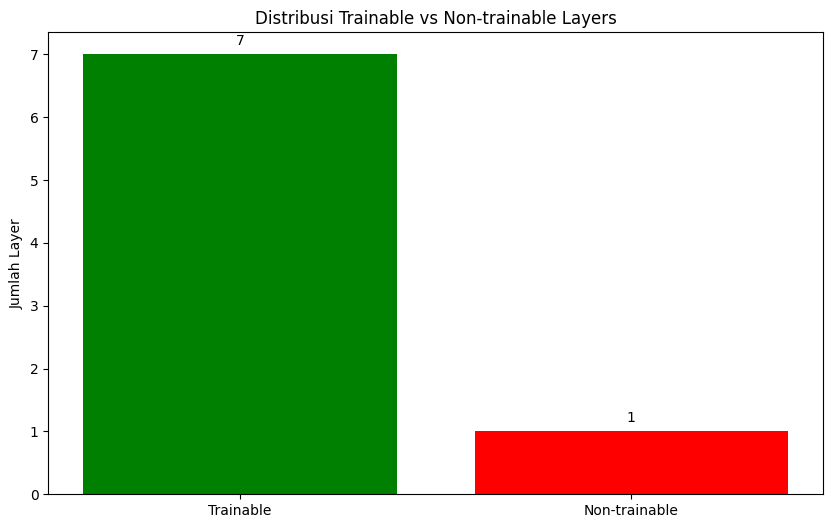

In [8]:
# Menampilkan layer-layer model
print("STRUKTUR MODEL TRANSFER LEARNING")
print("="*50)

# Hitung jumlah layer yang freeze dan trainable
total_layers = len(model.layers)
base_layers = len(base_model.layers)
trainable_layers = sum([1 for layer in model.layers if layer.trainable])
non_trainable_layers = total_layers - trainable_layers

print(f"Total layers: {total_layers}")
print(f"Base model layers: {base_layers}")
print(f"Trainable layers: {trainable_layers}")
print(f"Non-trainable layers: {non_trainable_layers}")
print(f"Percentage trainable: {(trainable_layers/total_layers)*100:.2f}%")

# Plot distribusi layer
plt.figure(figsize=(10, 6))
layer_types = ['Trainable', 'Non-trainable']
counts = [trainable_layers, non_trainable_layers]

plt.bar(layer_types, counts, color=['green', 'red'])
plt.title('Distribusi Trainable vs Non-trainable Layers')
plt.ylabel('Jumlah Layer')
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')
plt.show()

In [9]:
# Setup callbacks untuk training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Buat directory untuk menyimpan model
os.makedirs('saved_models', exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'saved_models/best_transfer_learning_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training fase 1: Hanya classifier head
print("FASE 1: Training Classifier Head")
print("="*40)

history_phase1 = model.fit(
    x_train_processed,
    y_train_processed,
    batch_size=32,
    epochs=20,
    validation_data=(x_test_processed, y_test_processed),
    callbacks=callbacks,
    verbose=1
)

FASE 1: Training Classifier Head
Epoch 1/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2767 - loss: 1.9505
Epoch 1: val_accuracy improved from -inf to 0.53890, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 94s 46ms/step - accuracy: 0.2768 - loss: 1.9502 - val_accuracy: 0.5389 - val_loss: 1.3107 - learning_rate: 0.0010
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5050 - loss: 1.4056
Epoch 2: val_accuracy improved from 0.53890 to 0.60990, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 45ms/step - accuracy: 0.5050 - loss: 1.4055 - val_accuracy: 0.6099 - val_loss: 1.1373 - learning_rate: 0.0010
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5613 - loss: 1.2799
Epoch 3: val_accuracy improved from 0.60990 to 0.63110, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.5613 - loss: 1.2799 - val_accuracy: 0.6311 - val_loss: 1.0683 - learning_rate: 0.0010
Epoch 4/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5857 - loss: 1.2027
Epoch 4: val_accuracy improved from 0.63110 to 0.67300, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.5857 - loss: 1.2027 - val_accuracy: 0.6730 - val_loss: 0.9648 - learning_rate: 0.0010
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6102 - loss: 1.1416
Epoch 5: val_accuracy improved from 0.67300 to 0.68800, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 85s 45ms/step - accuracy: 0.6102 - loss: 1.1416 - val_accuracy: 0.6880 - val_loss: 0.9170 - learning_rate: 0.0010
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6289 - loss: 1.0926
Epoch 6: val_accuracy improved from 0.68800 to 0.70310, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - accuracy: 0.6289 - loss: 1.0926 - val_accuracy: 0.7031 - val_loss: 0.8660 - learning_rate: 0.0010
Epoch 7/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6440 - loss: 1.0472
Epoch 7: val_accuracy improved from 0.70310 to 0.71030, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 92s 49ms/step - accuracy: 0.6440 - loss: 1.0472 - val_accuracy: 0.7103 - val_loss: 0.8536 - learning_rate: 0.0010
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6511 - loss: 1.0258
Epoch 8: val_accuracy improved from 0.71030 to 0.72180, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 134s 45ms/step - accuracy: 0.6511 - loss: 1.0258 - val_accuracy: 0.7218 - val_loss: 0.8151 - learning_rate: 0.0010
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6630 - loss: 0.9983
Epoch 9: val_accuracy improved from 0.72180 to 0.73720, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 92s 49ms/step - accuracy: 0.6630 - loss: 0.9983 - val_accuracy: 0.7372 - val_loss: 0.7844 - learning_rate: 0.0010
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6687 - loss: 0.9807
Epoch 10: val_accuracy did not improve from 0.73720
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.6687 - loss: 0.9807 - val_accuracy: 0.7275 - val_loss: 0.7910 - learning_rate: 0.0010
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6717 - loss: 0.9619
Epoch 11: val_accuracy did not improve from 0.73720
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - accuracy: 0.6717 - loss: 0.9619 - val_accuracy: 0.7326 - val_loss: 0.7712 - learning_rate: 0.0010
Epoch 12/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6777 - loss: 0.9532
Epoch 12: val_accuracy did not improve from 0.73720
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.6777 - loss: 0.9532 - val_accuracy: 0.7350 - val_loss: 0.7628 - learning_rate: 0

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 144s 45ms/step - accuracy: 0.6792 - loss: 0.9401 - val_accuracy: 0.7496 - val_loss: 0.7337 - learning_rate: 0.0010
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6865 - loss: 0.9249
Epoch 14: val_accuracy improved from 0.74960 to 0.75640, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.6865 - loss: 0.9249 - val_accuracy: 0.7564 - val_loss: 0.7088 - learning_rate: 0.0010
Epoch 15/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6908 - loss: 0.9149
Epoch 15: val_accuracy did not improve from 0.75640
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.6908 - loss: 0.9149 - val_accuracy: 0.7562 - val_loss: 0.7085 - learning_rate: 0.0010
Epoch 16/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6930 - loss: 0.9057
Epoch 16: val_accuracy improved from 0.75640 to 0.76300, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.6930 - loss: 0.9057 - val_accuracy: 0.7630 - val_loss: 0.6972 - learning_rate: 0.0010
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6939 - loss: 0.9032
Epoch 17: val_accuracy improved from 0.76300 to 0.76870, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.6939 - loss: 0.9032 - val_accuracy: 0.7687 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 18/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6987 - loss: 0.8866
Epoch 18: val_accuracy did not improve from 0.76870
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - accuracy: 0.6987 - loss: 0.8866 - val_accuracy: 0.7541 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6994 - loss: 0.8835
Epoch 19: val_accuracy did not improve from 0.76870
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.6995 - loss: 0.8835 - val_accuracy: 0.7640 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7028 - loss: 0.8801
Epoch 20: val_accuracy improved from 0.76870 to 0.77250, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - accuracy: 0.7028 - loss: 0.8801 - val_accuracy: 0.7725 - val_loss: 0.6724 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 20.


In [10]:
# Fase 2: Fine-tuning dengan unfreeze beberapa layer base model
print("\nFASE 2: Fine-tuning dengan Unfreeze Beberapa Layer")
print("="*50)

# Unfreeze beberapa layer terakhir dari base model
base_model.trainable = True

# Freeze layer awal, unfreeze layer akhir
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompile dengan learning rate lebih rendah
model.compile(
    optimizer=Adam(learning_rate=0.0001/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Unfreezed {len(base_model.layers) - fine_tune_at} layer terakhir")
print(f"Total trainable weights: {sum([w.shape.num_elements() for w in model.trainable_weights])}")

# Training fase 2
history_phase2 = model.fit(
    x_train_processed,
    y_train_processed,
    batch_size=32,
    epochs=15,
    validation_data=(x_test_processed, y_test_processed),
    callbacks=callbacks,
    verbose=1
)


FASE 2: Fine-tuning dengan Unfreeze Beberapa Layer
Unfreezed 30 layer terakhir
Total trainable weights: 1699274
Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2095 - loss: 31.5414
Epoch 1: val_accuracy did not improve from 0.77250
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 213s 107ms/step - accuracy: 0.2095 - loss: 31.5341 - val_accuracy: 0.0903 - val_loss: 9.6885 - learning_rate: 1.0000e-05
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3317 - loss: 5.0285
Epoch 2: val_accuracy did not improve from 0.77250
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 198s 106ms/step - accuracy: 0.3318 - loss: 5.0281 - val_accuracy: 0.1240 - val_loss: 4.7737 - learning_rate: 1.0000e-05
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3937 - loss: 2.8232
Epoch 3: val_accuracy did not improve from 0.77250
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 208s 109ms/step - accuracy: 0.3937 - loss: 2.8231 - val_accuracy: 0.4380 - val_loss: 1.7769 - learning_rate: 1.0000e-05
Epoch 4/1

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 201s 107ms/step - accuracy: 0.6348 - loss: 1.1519 - val_accuracy: 0.7807 - val_loss: 0.6834 - learning_rate: 1.0000e-05
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6778 - loss: 1.0161
Epoch 8: val_accuracy improved from 0.78070 to 0.80380, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 203s 108ms/step - accuracy: 0.6778 - loss: 1.0161 - val_accuracy: 0.8038 - val_loss: 0.6078 - learning_rate: 1.0000e-05
Epoch 9/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7125 - loss: 0.9137
Epoch 9: val_accuracy improved from 0.80380 to 0.83160, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 212s 113ms/step - accuracy: 0.7125 - loss: 0.9137 - val_accuracy: 0.8316 - val_loss: 0.5445 - learning_rate: 1.0000e-05
Epoch 10/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7414 - loss: 0.8211
Epoch 10: val_accuracy improved from 0.83160 to 0.84880, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 202s 108ms/step - accuracy: 0.7414 - loss: 0.8211 - val_accuracy: 0.8488 - val_loss: 0.4985 - learning_rate: 1.0000e-05
Epoch 11/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7667 - loss: 0.7366
Epoch 11: val_accuracy improved from 0.84880 to 0.86430, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 207s 110ms/step - accuracy: 0.7667 - loss: 0.7366 - val_accuracy: 0.8643 - val_loss: 0.4502 - learning_rate: 1.0000e-05
Epoch 12/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7912 - loss: 0.6521
Epoch 12: val_accuracy improved from 0.86430 to 0.87560, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 201s 107ms/step - accuracy: 0.7912 - loss: 0.6521 - val_accuracy: 0.8756 - val_loss: 0.4175 - learning_rate: 1.0000e-05
Epoch 13/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8049 - loss: 0.6085
Epoch 13: val_accuracy improved from 0.87560 to 0.88260, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 202s 108ms/step - accuracy: 0.8049 - loss: 0.6085 - val_accuracy: 0.8826 - val_loss: 0.3981 - learning_rate: 1.0000e-05
Epoch 14/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8240 - loss: 0.5522
Epoch 14: val_accuracy improved from 0.88260 to 0.89180, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 201s 107ms/step - accuracy: 0.8240 - loss: 0.5522 - val_accuracy: 0.8918 - val_loss: 0.3772 - learning_rate: 1.0000e-05
Epoch 15/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8364 - loss: 0.4993
Epoch 15: val_accuracy improved from 0.89180 to 0.89850, saving model to saved_models/best_transfer_learning_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 203s 108ms/step - accuracy: 0.8364 - loss: 0.4993 - val_accuracy: 0.8985 - val_loss: 0.3610 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 15.


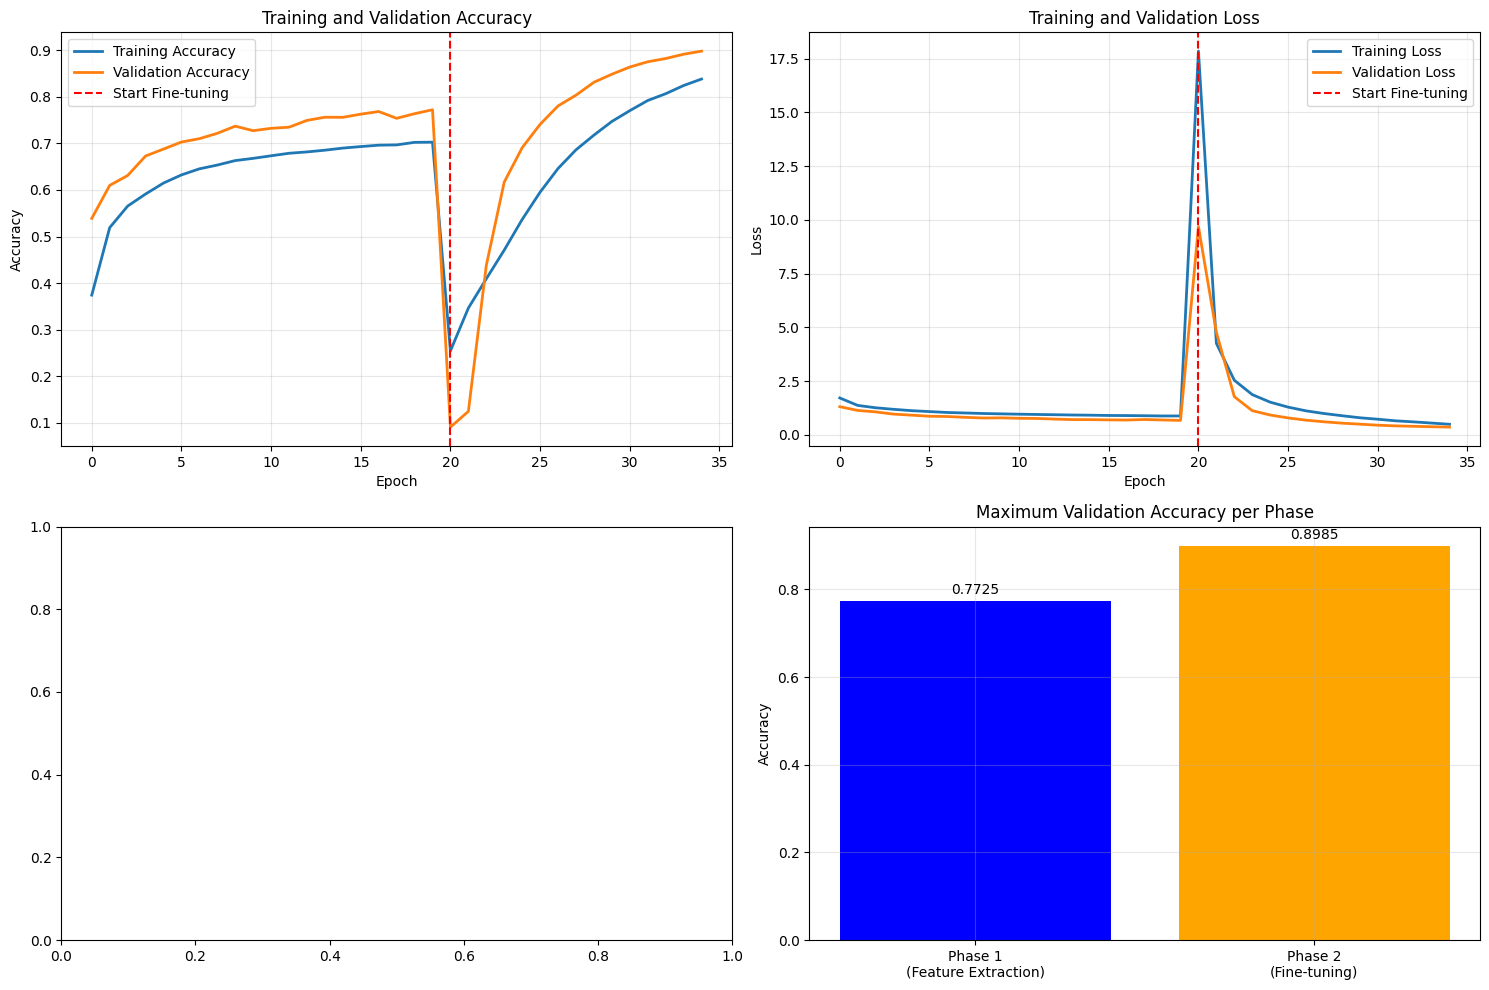

In [11]:
# Gabungkan history dari kedua fase training
def combine_histories(hist1, hist2):
    combined_history = {}
    for key in hist1.history.keys():
        combined_history[key] = hist1.history[key] + hist2.history[key]
    return combined_history

combined_history = combine_histories(history_phase1, history_phase2)

# Plot training history
plt.figure(figsize=(15, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.plot(combined_history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--',
            label='Start Fine-tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(2, 2, 2)
plt.plot(combined_history['loss'], label='Training Loss', linewidth=2)
plt.plot(combined_history['val_loss'], label='Validation Loss', linewidth=2)
plt.axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--',
            label='Start Fine-tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot learning rate
plt.subplot(2, 2, 3)
if 'lr' in combined_history:
    plt.plot(combined_history['lr'], label='Learning Rate', linewidth=2, color='purple')
    plt.axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--')
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot perbandingan fase
plt.subplot(2, 2, 4)
phases = ['Phase 1\n(Feature Extraction)', 'Phase 2\n(Fine-tuning)']
max_acc_phase1 = max(history_phase1.history['val_accuracy'])
max_acc_phase2 = max(history_phase2.history['val_accuracy'])
max_accuracies = [max_acc_phase1, max_acc_phase2]

plt.bar(phases, max_accuracies, color=['blue', 'orange'])
plt.title('Maximum Validation Accuracy per Phase')
plt.ylabel('Accuracy')
for i, acc in enumerate(max_accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ANALISIS HASIL TRAINING
Final Training Accuracy: 0.8385
Final Validation Accuracy: 0.8985
Best Validation Accuracy: 0.8985 (epoch 35)
Overfitting: No

Improvement dari Fine-tuning: 0.1260 (12.60%)


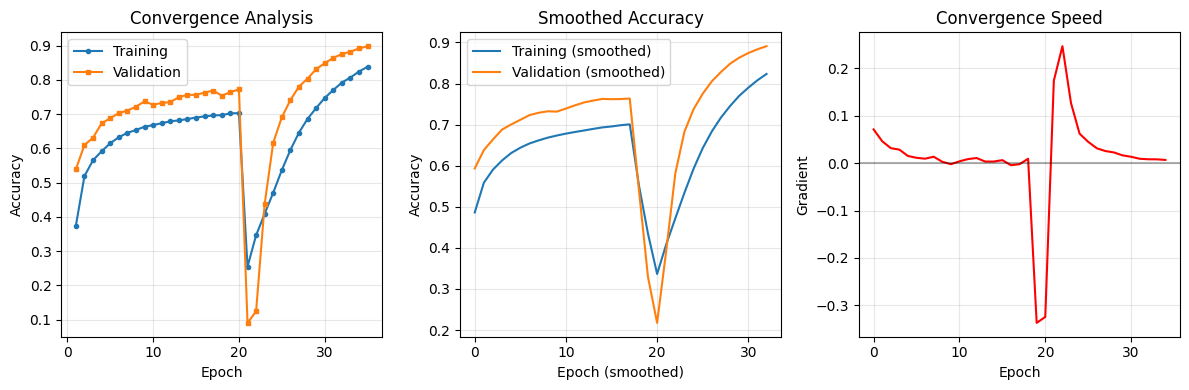

In [12]:
# Analisis hasil training
print("ANALISIS HASIL TRAINING")
print("="*50)

final_train_acc = combined_history['accuracy'][-1]
final_val_acc = combined_history['val_accuracy'][-1]
best_val_acc = max(combined_history['val_accuracy'])
best_val_epoch = combined_history['val_accuracy'].index(best_val_acc) + 1

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} (epoch {best_val_epoch})")
print(f"Overfitting: {'Yes' if final_train_acc - final_val_acc > 0.05 else 'No'}")

# Hitung improvement dari fase 1 ke fase 2
phase1_final_acc = history_phase1.history['val_accuracy'][-1]
phase2_final_acc = history_phase2.history['val_accuracy'][-1]
improvement = phase2_final_acc - phase1_final_acc

print(f"\nImprovement dari Fine-tuning: {improvement:.4f} ({improvement*100:.2f}%)")

# Plot convergence analysis
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
epochs_range = range(1, len(combined_history['accuracy']) + 1)
plt.plot(epochs_range, combined_history['accuracy'], label='Training', marker='o', markersize=3)
plt.plot(epochs_range, combined_history['val_accuracy'], label='Validation', marker='s', markersize=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convergence Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
# Smoothing untuk visualisasi yang lebih baik
window = 3
smoothed_train = np.convolve(combined_history['accuracy'], np.ones(window)/window, mode='valid')
smoothed_val = np.convolve(combined_history['val_accuracy'], np.ones(window)/window, mode='valid')
plt.plot(smoothed_train, label='Training (smoothed)')
plt.plot(smoothed_val, label='Validation (smoothed)')
plt.xlabel('Epoch (smoothed)')
plt.ylabel('Accuracy')
plt.title('Smoothed Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Gradient of accuracy (convergence speed)
grad_acc = np.gradient(combined_history['val_accuracy'])
plt.plot(grad_acc, color='red')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Gradient')
plt.title('Convergence Speed')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

EVALUASI MODEL PADA TEST SET
Test Loss: 0.3610
Test Accuracy: 0.8985
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       980
           1       1.00      0.97      0.99      1135
           2       0.88      0.82      0.85      1032
           3       0.90      0.89      0.89      1010
           4       0.84      0.90      0.87       982
           5       0.81      0.89      0.85       892
           6       0.89      0.95      0.92       958
           7       0.93      0.88      0.90      1028
           8       0.92      0.83      0.87       974
           9       0.85      0.89      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



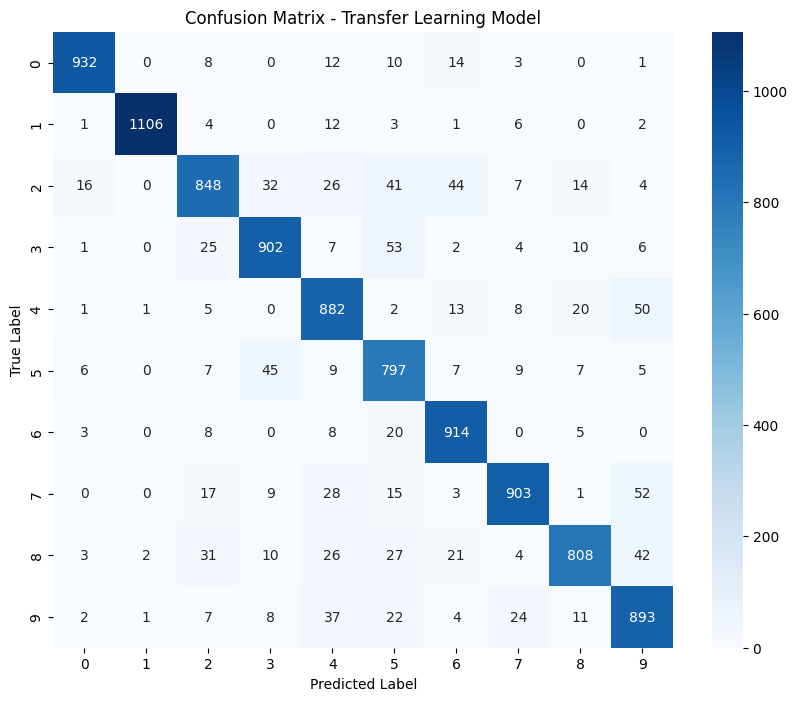

In [13]:
# Evaluasi model pada test set
print("EVALUASI MODEL PADA TEST SET")
print("="*40)

test_loss, test_accuracy = model.evaluate(x_test_processed, y_test_processed, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Prediksi pada test set
y_pred = model.predict(x_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_processed, axis=1)

# Classification report
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Transfer Learning Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [14]:
# Load model CNN dari bab sebelumnya untuk perbandingan
try:
    cnn_model = keras.models.load_model('mnist_cnn_model.h5')

    # Evaluate CNN model
    x_test_cnn = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(x_test_cnn, y_test, verbose=0)

    print("\nPERBANDINGAN MODEL")
    print("="*40)
    print(f"Transfer Learning Model - Test Accuracy: {test_accuracy:.4f}")
    print(f"CNN Model dari Awal - Test Accuracy: {cnn_test_accuracy:.4f}")

    # Plot perbandingan
    models = ['CNN dari Awal', 'Transfer Learning']
    accuracies = [cnn_test_accuracy, test_accuracy]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(models, accuracies, color=['blue', 'orange'])
    plt.ylabel('Test Accuracy')
    plt.title('Perbandingan Akurasi Model')
    plt.ylim(0, 1)

    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.4f}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3)
    plt.show()

except:
    print("Model CNN dari bab sebelumnya tidak ditemukan")

Model CNN dari bab sebelumnya tidak ditemukan


In [15]:
# Simpan model final
model.save('saved_models/final_transfer_learning_model.h5')
print("Model final telah disimpan!")

# Simpan training history
import pickle
with open('saved_models/training_history.pkl', 'wb') as f:
    pickle.dump(combined_history, f)

print("Training history telah disimpan!")

# Ringkasan hasil
print("\n" + "="*50)
print("RINGKASAN IMPLEMENTASI TRANSFER LEARNING")
print("="*50)
print(f"Arsitektur: MobileNetV2")
print(f"Input Shape: (32, 32, 3)")
print(f"Training Strategy: Two-phase (Feature Extraction + Fine-tuning)")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Total Epochs: {len(combined_history['accuracy'])}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Model final telah disimpan!
Training history telah disimpan!

RINGKASAN IMPLEMENTASI TRANSFER LEARNING
Arsitektur: MobileNetV2
Input Shape: (32, 32, 3)
Training Strategy: Two-phase (Feature Extraction + Fine-tuning)
Final Test Accuracy: 0.8985
Total Epochs: 35
Best Validation Accuracy: 0.8985
